In [1]:
# SETUP
## Importing libs
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

## Random params
np.random.seed(0)
random_state = 338

## Plot params
%matplotlib inline
np.random.seed(0)
plt.rcParams['figure.figsize'] = [20, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
sns.set_theme(context="notebook")

## Load train and test
test = pd.read_csv('../test.csv', index_col='id')
dT = pd.read_csv('../train.csv', index_col='id')

X = dT.drop('claim',axis =1).copy()
y = dT['claim']

test = test.fillna(test.mean())
X= X.fillna(X.mean())

test = test.fillna(test.mean())
X= X.fillna(X.mean())

X.head()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f109,f110,f111,f112,f113,f114,f115,f116,f117,f118
id,,,,,,,,,,,,,,,,,,,,,
0,0.10859,0.004314,-37.566,0.017364,0.28915,-10.25100,135.12,168900.0,3.992400e+14,86.489,...,0.11093,-12.2280,1.7482,1.90960,-7.11570,4378.80,1.2096,8.613400e+14,140.100000,1.01770
1,0.10090,0.299610,11822.000,0.276500,0.45970,-0.83733,1721.90,119810.0,3.874100e+15,9953.600,...,0.97673,-56.7580,4.1684,0.34808,4.14200,913.23,1.2464,7.575100e+15,1861.000000,0.28359
2,0.17803,-0.006980,907.270,0.272140,0.45948,0.17327,2298.00,360650.0,1.224500e+13,15827.000,...,0.20102,-5.7688,1.2042,0.26290,8.13120,45119.00,1.1764,3.218100e+14,3838.200000,0.40690
3,0.15236,0.007259,780.100,0.025179,0.51947,7.49140,112.51,259490.0,7.781400e+13,-36.837,...,-0.01182,-34.8580,2.0694,0.79631,-16.33600,4952.40,1.1784,4.533000e+12,4889.100000,0.51486
4,0.11623,0.502900,-109.150,0.297910,0.34490,-0.40932,2538.90,65332.0,1.907200e+15,144.120,...,0.92739,-13.6410,1.5298,1.14640,-0.43124,3856.50,1.4830,-8.991300e+12,3959.204669,0.23049


In [9]:
from sklearn.metrics import roc_auc_score

from catboost import CatBoostClassifier 
import xgboost as xgb
import lightgbm as lgb

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.70, random_state=42)

clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train,eval_metric = 'AUC', verbose=False)
preds_valid_LGBM = clf.predict_proba(X_test)[:,1]
PD_LGBM = roc_auc_score(y_test, preds_valid_LGBM)
print(PD_LGBM)

xgbc = xgb.XGBClassifier(use_label_encoder=False)
xgbc.fit(X_train, y_train, eval_metric = 'logloss', verbose=True)
preds_valid_XGB = xgbc.predict_proba(X_test)[:,1]
PD_XGB = roc_auc_score(y_test, preds_valid_XGB)
print(PD_XGB)

catBOOST = CatBoostClassifier(iterations=1000, task_type="GPU", devices='0:1', eval_metric='AUC')
catBOOST.fit(X_train, y_train, verbose=False)
preds_valid_CAT = catBOOST.predict_proba(X_test)[:,1]
PD_CAT = roc_auc_score(y_test, preds_valid_CAT)
print(PD_CAT)

0.7560644295743563


C:\Users\alexa\AppData\Local\Programs\Python\Python38\lib\site-packages\cupy\_environment.py:213: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(


0.7618611998190309
0.7834926407148233


In [17]:
## Atualizar X e y
novo_X = X_test.copy()
novo_teste  = test.copy()
novo_y = y_test.copy()

novo_X['lgb'] = PD_LGBM*clf.predict_proba(novo_X)[:,1]
novo_X['xgb'] = PD_XGB*xgbc.predict_proba(novo_X.drop('lgb',axis=1))[:,1]
novo_X['cat'] = PD_CAT*catBOOST.predict_proba(novo_X.drop(['lgb','xgb'],axis=1))[:,1]

novo_teste['lgb'] = PD_LGBM*clf.predict_proba(novo_teste)[:,1]
novo_teste['xgb'] = PD_XGB*xgbc.predict_proba(novo_teste.drop('lgb',axis=1))[:,1]
novo_teste['cat'] = PD_CAT*catBOOST.predict_proba(novo_teste.drop(['lgb','xgb'],axis=1))[:,1]

print(novo_X.shape)
print(novo_y.shape)
novo_X.head()

C:\Users\alexa\AppData\Local\Programs\Python\Python38\lib\site-packages\cupy\_environment.py:213: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(


(670544, 121)
(670544,)


,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f112,f113,f114,f115,f116,f117,f118,lgb,xgb,cat
id,,,,,,,,,,,,,,,,,,,,,
682721,0.090452,0.345964,1159.10,0.061711,-0.001278,-0.071458,1776.900,884250.0,7.183000e+15,1557.50,...,7.5888,3.2722,21347.00,1.1392,2.630500e+16,9856.3,0.28264,0.372396,0.404850,0.440509
470979,0.101340,0.339360,5135.10,0.026545,0.452970,-0.893230,325.060,625440.0,3.302400e+15,46176.00,...,4.1902,3.9285,22707.00,1.3137,8.625500e+16,1113.4,0.67445,0.457533,0.347324,0.475454
394613,0.089833,0.348380,267.65,0.258370,0.289470,-0.555780,2574.100,543770.0,1.207300e+15,7527.30,...,3.0347,-14.7140,1276.80,1.4042,2.582200e+17,2444.2,0.15358,0.366486,0.502375,0.485903
329967,0.060176,0.384480,686.14,0.469660,0.379170,-7.257900,1435.800,25703.0,9.066400e+13,790.37,...,1.6269,-9.7697,221.75,1.1908,8.960300e+13,2168.4,0.64688,0.333934,0.325414,0.313808
711757,0.101090,0.359360,11966.00,0.044494,0.221100,2.657200,39.691,622360.0,3.004000e+14,968.75,...,-2.0261,1.8200,27393.00,1.2971,9.521400e+15,11143.0,0.26185,0.323986,0.359608,0.300241


In [20]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=10, random_state=random_state, shuffle=True)
skf.get_n_splits(novo_X, novo_y)

final_predictions = []
history = []

for fold, (train_indicies, valid_indicies) in enumerate(skf.split(X=novo_X,y=novo_y)):
    X_train = novo_X.iloc[train_indicies]
    X_valid = novo_X.iloc[valid_indicies]
    X_test = novo_teste.copy()
    
    y_train = novo_y.iloc[train_indicies]
    y_valid = novo_y.iloc[valid_indicies]

    catBOOST = CatBoostClassifier(
                        task_type="GPU",
                        devices='0:1',
                        eval_metric='AUC'
                        )
    catBOOST.fit(X_train,
            y_train,
            verbose=True,
            plot=False)

    preds_valid = catBOOST.predict_proba(X_valid)[:,1]
    preds_test = catBOOST.predict_proba(X_test)[:,1]
    
    final_predictions.append(preds_test)
    history.append([fold, roc_auc_score(y_valid, preds_valid)])
    print(history[-1])

Learning rate set to 0.023705
0:	learn: 0.7815685	total: 89.9ms	remaining: 1m 29s
1:	learn: 0.7832571	total: 147ms	remaining: 1m 13s
2:	learn: 0.7833796	total: 228ms	remaining: 1m 15s
3:	learn: 0.7839548	total: 275ms	remaining: 1m 8s
4:	learn: 0.7842398	total: 314ms	remaining: 1m 2s
5:	learn: 0.7842713	total: 365ms	remaining: 1m
6:	learn: 0.7857468	total: 413ms	remaining: 58.6s
7:	learn: 0.7857132	total: 477ms	remaining: 59.2s
8:	learn: 0.7858640	total: 515ms	remaining: 56.7s
9:	learn: 0.7860421	total: 558ms	remaining: 55.3s
10:	learn: 0.7863328	total: 599ms	remaining: 53.9s
11:	learn: 0.7866935	total: 636ms	remaining: 52.3s
12:	learn: 0.7869774	total: 668ms	remaining: 50.7s
13:	learn: 0.7870151	total: 709ms	remaining: 49.9s
14:	learn: 0.7875558	total: 753ms	remaining: 49.4s
15:	learn: 0.7876561	total: 804ms	remaining: 49.4s
16:	learn: 0.7876475	total: 858ms	remaining: 49.6s
17:	learn: 0.7879520	total: 910ms	remaining: 49.6s
18:	learn: 0.7878963	total: 951ms	remaining: 49.1s
19:	learn:

[[0, 0.7986437990415702], [1, 0.7964223593864573], [2, 0.7968137218205227], [3, 0.7977637891312283], [4, 0.7971374801320161], [5, 0.7950253201696802], [6, 0.7976386132721067], [7, 0.8009493475614758], [8, 0.797836467102876], [9, 0.7974445307829332]]

 Fold com melhores resultados: 7

 Resultado nesse fold: 0.8009493475614758

 Média dos resultados:: [4.5        0.79756754]
Media das propostas na submissão: id       1.204656e+08
claim    3.382665e+01
dtype: float64


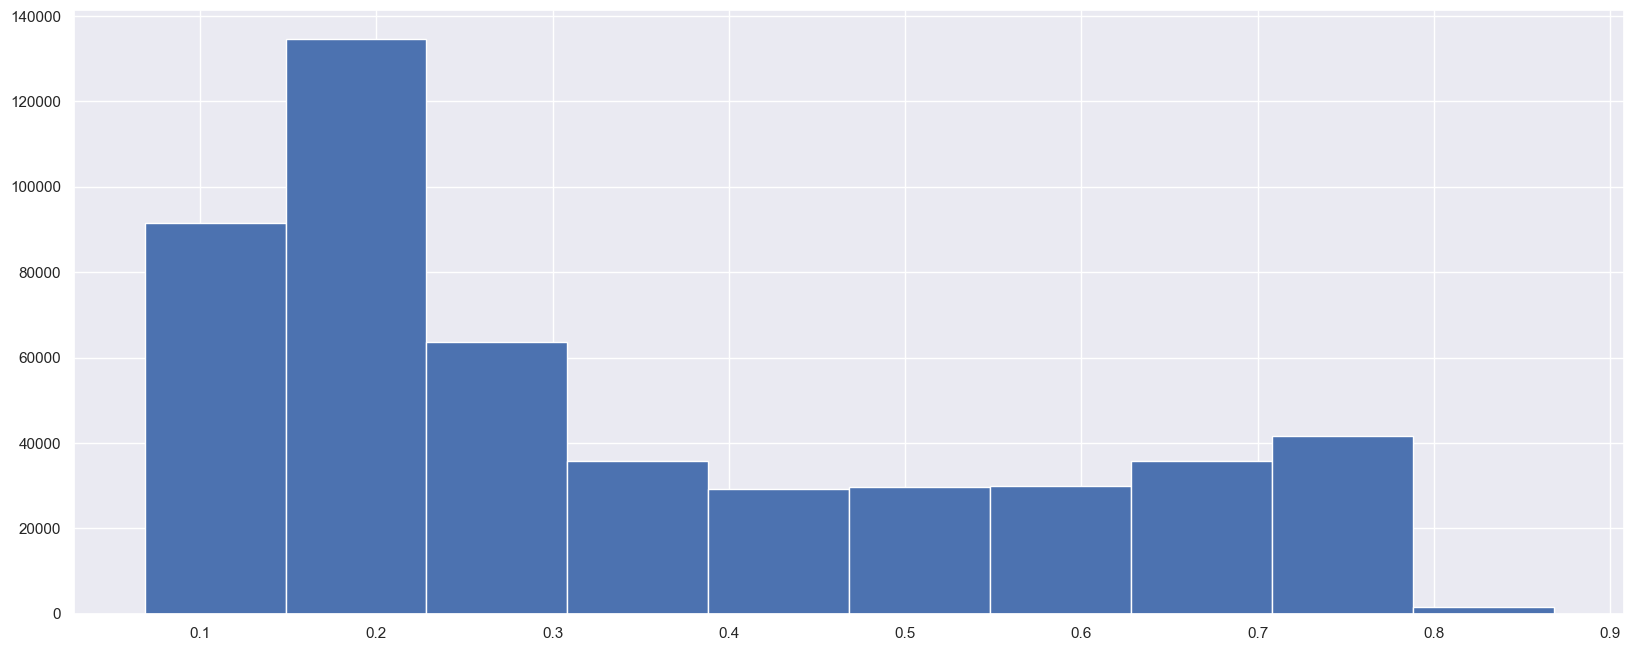

In [25]:
# gera submissao
print(history)
maior =0.0
for ii in range(len(history)):
    # print(history[ii][1])
    if history[ii][1]>maior:
        maior = history[ii][1]
        # print(maior)
        max_index = ii
print('\n Fold com melhores resultados:',max_index)
print('\n Resultado nesse fold:',history[max_index][1])
print('\n Média dos resultados::',np.mean(history,axis = 0))
sub = final_predictions[:][max_index]
mysub = pd.DataFrame(novo_teste.index)
mysub['claim'] = sub
mysub['claim'] = mysub['claim'].fillna(0)
print('Media das propostas na submissão:',mysub.mean()*100)
mysub['claim'].hist()
var = 'ensembleTest_mistureba_jogada_no_catboost'
mysub.to_csv(var+'_submisssion.csv',index=False)